In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-03-09 16:02:10.595899: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

import cv2
import os
import numpy as np

In [3]:
from test_train_data import x_train, x_test, y_train, y_test

In [4]:
# Load a pre-trained model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(100, 100, 3))

# Freeze all layers except the last one
for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
predictions = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()


2023-03-09 16:03:10.379885: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 16:03:10.507966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14786 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:89:00.0, compute capability: 7.0


94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 25, 25, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 25, 25, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 25, 25, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 13, 13, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 13, 13, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 13, 13, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 7, 7, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 7, 7, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 7, 7, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 7, 7, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 7, 7, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 7, 7, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

In [5]:
# train the model
model.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test))

Epoch 1/15


2023-03-09 16:03:22.021842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-03-09 16:03:22.386375: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9454cb0bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-09 16:03:22.386415: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-03-09 16:03:22.392647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-09 16:03:22.528906: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


324/324 [==============================] - 12s 24ms/step - loss: 0.5484 - accuracy: 0.7308 - val_loss: 0.5067 - val_accuracy: 0.7497
Epoch 2/15
324/324 [==============================] - 6s 17ms/step - loss: 0.4830 - accuracy: 0.7547 - val_loss: 0.5172 - val_accuracy: 0.7416
Epoch 3/15
324/324 [==============================] - 6s 17ms/step - loss: 0.4895 - accuracy: 0.7571 - val_loss: 0.5130 - val_accuracy: 0.7480
Epoch 4/15
324/324 [==============================] - 6s 17ms/step - loss: 0.4637 - accuracy: 0.7679 - val_loss: 0.4634 - val_accuracy: 0.7523
Epoch 5/15
324/324 [==============================] - 6s 17ms/step - loss: 0.4501 - accuracy: 0.7716 - val_loss: 0.4302 - val_accuracy: 0.7879
Epoch 6/15
324/324 [==============================] - 6s 17ms/step - loss: 0.4397 - accuracy: 0.7802 - val_loss: 0.4043 - val_accuracy: 0.7981
Epoch 7/15
324/324 [==============================] - 6s 17ms/step - loss: 0.4248 - accuracy: 0.7899 - val_loss: 0.5293 - val_accuracy: 0.7315
Epoch 8/1

In [6]:
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.825, Test: 0.828


In [7]:
# find accuracy, precision, recall, f1 score, jaccard index, kappa score, confusion matrix, ROC curve, AUC score, etc.

# precision
from sklearn.metrics import precision_score
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)

# recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='macro')
print('Recall: %f' % recall)

# f1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='macro')
print('F1 score: %f' % f1)

# jaccard index
from sklearn.metrics import jaccard_score
jaccard = jaccard_score(y_test, y_pred, average='macro')
print('Jaccard score: %f' % jaccard)

# kappa score
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)

# confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(fpr, tpr, thresholds)

# AUC score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC=%.3f' % (auc))

108/108 [==============================] - 2s 10ms/step
Precision: 0.369930
Recall: 0.500000
F1 score: 0.425241
Jaccard score: 0.369930
Cohens kappa: 0.000000
[[2554    0]
 [ 898    0]]
[0. 1.] [0. 1.] [1 0]
ROC AUC=0.500


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


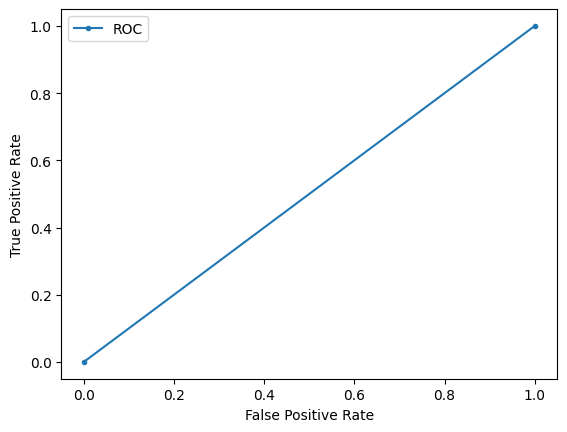

In [8]:

# roc curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='ROC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()